In [1]:
import os
import sys
import pickle
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.special import expit
import pystan
import multiprocessing

In [2]:
import import_ipynb
from model import Model, ModelLocBias

importing Jupyter notebook from model.ipynb
The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


In [3]:
multiprocessing.set_start_method("fork") # For multiprocessing in stan
sns.set()  # Nice plot aesthetic
np.random.seed(101)

In [4]:
FIG_FOLDER = 'fig'
SOURCE_FOLDER = os.path.join('data', 'source')
BACKUP_FOLDER = os.path.join('data', 'backup')
print(f"The source folder is: {os.path.abspath(SOURCE_FOLDER)}")
print(f"The figure folder is: {os.path.abspath(FIG_FOLDER)}")
print(f"The backup folder is: {os.path.abspath(BACKUP_FOLDER)}")

# Create folders
for f in SOURCE_FOLDER, FIG_FOLDER, BACKUP_FOLDER:
    os.makedirs(f, exist_ok=True)

The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


In [5]:
DATASET = "A"

# Load the data

In [6]:
df_fit = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_fit_overall{DATASET}.csv"))
for c in ("date_begin", "date_end"):
    df_fit[c] = pd.to_datetime(df_fit[c])
df_fit.drop(df_fit.filter(regex="Unname"),axis=1, inplace=True)
df_fit

,distortion,precision,risk_aversion,date_begin,date_end,monkey,condition,n
0,1.327630,0.287248,0.206550,2020-02-22,2020-06-22,Ala,gain,8326
1,1.052253,0.236651,-0.584820,2020-02-22,2020-06-22,Ala,loss,8285
2,0.749594,0.937215,0.101506,2020-02-22,2020-06-22,Alv,gain,9996
3,0.487126,0.674161,-0.358318,2020-02-22,2020-06-22,Alv,loss,9988
4,0.917492,0.500987,-0.110538,2020-02-22,2020-06-22,Bar,gain,10361
5,0.767019,0.203717,-0.637882,2020-02-22,2020-06-22,Bar,loss,10365
6,1.800000,8.078418,0.990000,2020-02-23,2020-06-22,Ola,gain,5235
7,0.516030,5.732120,-0.657987,2020-02-23,2020-06-22,Ola,loss,5237
8,0.200000,4.141394,0.990000,2020-05-20,2020-06-18,Yin,gain,389
9,0.296324,10.000000,0.990000,2020-05-20,2020-06-19,Yin,loss,382


In [7]:
df_elo = pd.read_csv(os.path.join(BACKUP_FOLDER, "df_elo.csv"), index_col=0)
df_elo.index = pd.to_datetime(df_elo.index)
df_elo

,nem,yak,ner,yoh,nen,wot,pac,las,anu,ola,...,olg,jea,pat,bar,ces,lad,ber,dor,eri,fic
date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,1024,1009,1018,984,991,1010,991,982,991,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-26,1032,1009,1018,1003,991,1010,982,964,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-27,1032,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-28,1041,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-29,1063,1009,1018,1011,991,1010,975,941,984,1008,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-21,938,1243,961,840,1018,1234,1379,713,1117,1287,...,933,760,841,1083,837,753,743,766,702,579
2020-10-22,970,1243,962,840,1018,1234,1347,716,1105,1296,...,935,755,841,1070,832,753,743,795,702,566
2020-10-23,971,1243,970,840,1018,1234,1347,735,1105,1296,...,920,751,841,1072,838,753,758,773,668,566


In [8]:
df_demo = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_demo.csv"))
df_demo.weighing_date = pd.to_datetime(df_demo.weighing_date)
df_demo.birthdate = pd.to_datetime(df_demo.birthdate)
df_demo

,monkey,sex,birthdate,weight,weighing_date,age
0,Abr,M,2013-05-14,12.7,2020-01-13,7.670481
1,Ala,M,2013-03-19,12.6,2020-01-13,7.823804
2,Alv,M,2013-02-12,14.6,2020-01-13,7.919631
3,Anu,M,2013-05-21,15.5,2020-01-13,7.651316
4,Bar,M,2014-12-05,10.6,2020-01-13,6.109874
5,Ber,F,2014-11-13,8.4,2020-01-13,6.170108
6,Ces,M,2015-06-05,6.8,2020-01-13,5.611575
7,Dor,F,2016-03-22,4.9,2020-01-13,4.814844
8,Eri,M,2017-03-28,4.1,2020-01-13,3.799081
9,Fic,F,2018-02-21,3.2,2020-01-13,2.895571


# Prepare the data

In [16]:
elo = []

for _, row in df_fit.iterrows():
        
    m = row.monkey
    begin = row.date_begin
    end = row.date_end
        
    df_elo_m = df_elo[m.lower()]
    df_elo_m = df_elo_m[(df_elo_m.index >= begin) & (df_elo_m.index <= end)]
    elo.append(np.mean(df_elo_m))
        

df_fit['elo'] = elo
df_fit

,distortion,precision,risk_aversion,loc_bias,date_begin,date_end,monkey,condition,n,elo
0,1.327775,0.285684,0.206004,0.051842,2020-02-22,2020-06-22,Ala,gain,8326,1106.786885
1,1.051529,0.231330,-0.582592,-0.071694,2020-02-22,2020-06-22,Ala,loss,8285,1106.786885
2,0.768159,0.447276,0.075584,-0.936214,2020-02-22,2020-06-22,Alv,gain,9996,1096.295082
3,0.462213,0.229596,-0.398661,-0.675575,2020-02-22,2020-06-22,Alv,loss,9988,1096.295082
4,0.915509,0.492803,-0.109141,-0.117283,2020-02-22,2020-06-22,Bar,gain,10361,998.040984
5,0.769959,0.189979,-0.640682,-0.121369,2020-02-22,2020-06-22,Bar,loss,10365,998.040984
6,0.250000,1.612589,0.083753,-10.000000,2020-02-23,2020-06-22,Ola,gain,5235,1426.305785
7,0.250000,0.330200,-0.903815,-1.570219,2020-02-23,2020-06-22,Ola,loss,5237,1426.305785
8,0.610421,0.704556,0.750000,2.518428,2020-05-20,2020-06-18,Yin,gain,389,894.800000
9,0.888765,2.477640,0.571941,10.000000,2020-05-20,2020-06-19,Yin,loss,382,895.096774


In [10]:
left = df_fit[df_fit.condition == "loss"]
right = df_fit[df_fit.condition == "gain"]
df = pd.merge(left, right, on=("monkey", "elo", "date_begin", "date_end"), suffixes=('_loss', '_gain'))
df.drop("condition_gain", axis=1, inplace=True)
df.drop("condition_loss", axis=1, inplace=True)
for i, row in df.iterrows():
    try:
        df.loc[i, "age"] = df_demo.loc[df_demo.monkey == row.monkey, 'age'].item()
        df.loc[i, "weight"] = df_demo.loc[df_demo.monkey == row.monkey, 'weight'].item()
        df.loc[i, "sex"] = int(df_demo.loc[df_demo.monkey == row.monkey, 'sex'].item() == "M")
    except IndexError:
        print(row.monkey)
df

,distortion_loss,precision_loss,risk_aversion_loss,date_begin,date_end,monkey,n_loss,elo,distortion_gain,precision_gain,risk_aversion_gain,n_gain,age,weight,sex
0,1.052253,0.236651,-0.584820,2020-02-22,2020-06-22,Ala,8285,1106.786885,1.327630,0.287248,0.206550,8326,7.823804,12.6,1.0
1,0.487126,0.674161,-0.358318,2020-02-22,2020-06-22,Alv,9988,1096.295082,0.749594,0.937215,0.101506,9996,7.919631,14.6,1.0
2,0.767019,0.203717,-0.637882,2020-02-22,2020-06-22,Bar,10365,998.040984,0.917492,0.500987,-0.110538,10361,6.109874,10.6,1.0
3,0.516030,5.732120,-0.657987,2020-02-23,2020-06-22,Ola,5237,1426.305785,1.800000,8.078418,0.990000,5235,8.938132,16.5,1.0
4,0.610697,0.486810,-0.390098,2020-02-22,2020-06-22,Abr,6302,1262.409836,0.673916,0.333890,0.645185,6299,7.670481,12.7,1.0
5,0.743028,0.381228,-0.234483,2020-02-22,2020-06-22,Nem,5001,906.327869,0.787869,0.480714,0.406652,5008,10.025081,9.2,0.0
6,0.897922,0.485241,-0.219357,2020-02-23,2020-06-22,Ces,5632,757.801653,0.666329,0.330431,0.568596,5636,5.611575,6.8,1.0
7,0.360321,0.788312,-0.520387,2020-02-23,2020-06-22,Anu,3480,1174.388430,0.480326,0.412837,0.420829,3494,7.651316,15.5,1.0
8,0.800164,0.383459,-0.667373,2020-02-23,2020-06-22,Yoh,2840,806.785124,0.935791,0.483348,0.712016,2851,11.478910,10.0,0.0
9,0.598453,0.341182,-0.609874,2020-02-26,2020-06-22,Oli,2032,1203.288136,0.656230,0.704264,0.361250,2034,10.126384,15.0,1.0


In [11]:
# Convert dataframe into a dictionary adapted to Stan
data = df.to_dict('list')
data['N'] = len(data["distortion_gain"])
data.pop("date_begin")
data.pop("date_end")
data.pop("monkey")
data

{'distortion_loss': [1.052252697678462,
  0.4871262265240171,
  0.7670193394918364,
  0.5160302846681442,
  0.6106971898927989,
  0.743027584176668,
  0.897921918498676,
  0.3603213992841097,
  0.8001644891582302,
  0.5984525093744678,
  0.5390391453429033,
  0.4435639728781206,
  0.4941215159436743],
 'precision_loss': [0.2366509981785458,
  0.6741606451167367,
  0.2037170684727746,
  5.73211971756915,
  0.4868096953725465,
  0.3812278389184,
  0.4852413012228116,
  0.7883124961810563,
  0.3834591383952768,
  0.3411815221498672,
  0.4472191579592713,
  2.092978568833563,
  0.623430041402662],
 'risk_aversion_loss': [-0.5848200231358437,
  -0.3583181807449984,
  -0.6378815871709644,
  -0.6579871520783548,
  -0.3900981695815877,
  -0.2344833692611206,
  -0.2193569815681458,
  -0.5203874815807027,
  -0.6673725049534803,
  -0.6098737942106696,
  -0.7799556203010937,
  0.3801199341107799,
  -0.7670023086684007],
 'n_loss': [8285,
  9988,
  10365,
  5237,
  6302,
  5001,
  5632,
  3480,
  2

# Model 1

## Define the model

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [31]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_gain * distortion_gain
    + beta_risk_gain * risk_aversion_gain
    + beta_prec_gain * precision_gain
    + beta_dist_loss * distortion_loss
    + beta_risk_loss * risk_aversion_loss
    + beta_prec_loss * precision_loss
    , sigma);
}
"""

## Compile the model

In [32]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_file = os.path.join(BACKUP_FOLDER, 'regression_model.pkl')
if not os.path.exists(bkp_file) or force_compilation:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

## Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [33]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
fit

Inference for Stan model: anon_model_aef5dc0ffcff107725ff680927909285.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          1423.3   20.93 504.81 436.91 1124.5 1412.6 1710.2 2508.3    582    1.0
beta_dist_gain 848.27   30.46 675.62 -536.1 439.75 831.67 1248.9 2256.6    492    1.0
beta_risk_gain -48.56   17.87 471.51 -962.1 -361.4 -45.07  253.0 876.13    696    1.0
beta_prec_gain -108.6   22.42  472.4  -1038 -402.1 -109.2 156.41 835.94    444    1.0
beta_dist_loss  -1231   42.77 985.84  -3188  -1818  -1200 -612.1 683.45    531    1.0
beta_risk_loss 306.15   21.36 488.88 -637.1   5.57 294.92 591.05 1344.3    524    1.0
beta_prec_loss   38.2   33.78 709.59  -1345 -380.7  53.35 479.13 1448.5    441    1.0
sigma           277.4    4.91 103.36  149.8 205.73 254.59 320.96 534.09    443   1.01
lp__           -72.83    0.17   3.18 -8

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [34]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,1423.304218,20.927839,504.806459,436.912237,1124.593995,1412.611761,1710.274712,2508.377882,581.836609,1.002325
beta_dist_gain,848.272109,30.463808,675.621922,-536.174068,439.753157,831.672264,1248.900245,2256.658908,491.857246,1.004987
beta_risk_gain,-48.564585,17.869434,471.514300,-962.154285,-361.449651,-45.072180,252.996996,876.130445,696.254742,1.000202
beta_prec_gain,-108.691777,22.423982,472.403170,-1038.324530,-402.158525,-109.222198,156.408796,835.942756,443.813132,1.000596
beta_dist_loss,-1231.023004,42.768762,985.841746,-3188.591543,-1818.591312,-1200.296422,-612.138251,683.450400,531.325982,1.003972
beta_risk_loss,306.146210,21.362873,488.875706,-637.132864,5.568130,294.921396,591.046921,1344.369215,523.694009,1.003089
beta_prec_loss,38.198605,33.780446,709.585688,-1345.056256,-380.714292,53.353645,479.129549,1448.574275,441.244133,1.000648
sigma,277.395151,4.912029,103.363822,149.803068,205.734606,254.588772,320.957826,534.085692,442.807756,1.010430
lp__,-72.826450,0.167477,3.183325,-80.172398,-74.827648,-72.267200,-70.490254,-67.997603,361.288402,1.012209


## Plot the results

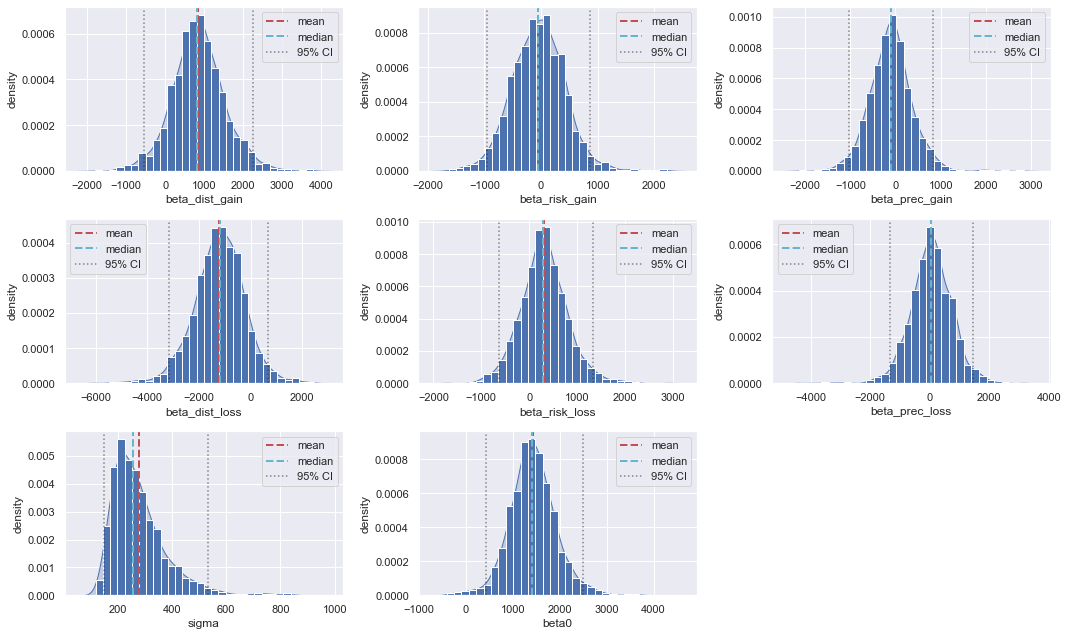

In [35]:
params = (
    "beta_dist_gain", "beta_risk_gain", "beta_prec_gain", 
    "beta_dist_loss", "beta_risk_loss", "beta_prec_loss",
    "sigma", "beta0")
nrows=3
ncols=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
axes = axes.flatten()

for i, param_name in enumerate(params):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    ax = axes[i]
    ax.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    ax.legend()
    
for i in range(len(params), ncols*nrows):
    fig.delaxes(axes[i])
    
plt.tight_layout()    
plt.show()

## Interpreation

In gain:
* proba: the more inverse s-shaped, the higher in the hierarchy?
* risk: no relation? tendance: the less risk averse, the higher in hierarchy
* precision: no relation? tendance: the less precise, the higher in hirearchy

In loss: 
* proba: no relation? tendance: the less inverse s-shpaed, the higher in hierarchy?
* risk: no relation? tendance: the less risk averse, the higher in hierarchy
* precision: no relation? tendance: the more precise, the higher in hierarchy

TO DO:

* Add age / weight / gender
* Model side bias
* Filtering data (side bias, low performance to control task, number of trials)
* Regression on performance
* Fit Vizualizing 

# Model 2 (with age, weight and gender)

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{sex} sex + \beta_{age} age + \beta_{weight} weight + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [54]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] weight;
    vector[N] age;
    vector[N] sex;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real beta_age;
    real beta_sex;
    real beta_wgt;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
        + beta_dist_gain * distortion_gain
        + beta_risk_gain * risk_aversion_gain
        + beta_prec_gain * precision_gain
        + beta_dist_loss * distortion_loss
        + beta_risk_loss * risk_aversion_loss
        + beta_prec_loss * precision_loss
        + beta_age * age
        + beta_wgt * weight
        + beta_sex * sex
        , sigma);
}
"""

## Compile the model

In [55]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_file = os.path.join(BACKUP_FOLDER, 'regression_model2.pkl')
if not os.path.exists(bkp_file) or force_compilation:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2dcdca10b8a351c703d9817ed6b00474 NOW.


## Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [68]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=10000, chains=4, warmup=1000, thin=1, seed=101, 
                  control=dict(adapt_delta=0.99, max_treedepth=100))
fit

Inference for Stan model: anon_model_2dcdca10b8a351c703d9817ed6b00474.
4 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=36000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          717.76   23.55 3143.7  -2446 127.47 728.97 1340.1 3844.2  17815    1.0
beta_dist_gain 645.78   31.68 3905.4  -3535 -116.2 662.33 1448.0 4723.5  15202    1.0
beta_risk_gain 202.43   15.81 1749.1  -1180 -71.66 190.48  453.5 1522.0  12247    1.0
beta_prec_gain -15.77     9.1 1002.7  -1166 -244.8 -25.27  195.8 1164.7  12137    1.0
beta_dist_loss  -1019    50.8 6146.0  -7200  -2260  -1044 162.43 5325.5  14640    1.0
beta_risk_loss  85.44   16.96 1662.1  -1455 -222.2  71.09 369.09 1655.1   9601    1.0
beta_prec_loss -101.9   17.86 1860.9  -1888 -439.2 -91.59 252.21 1688.2  10858    1.0
beta_age         37.4    1.47  173.3 -166.7  -0.12  38.77  77.37 232.34  13953    1.0
beta_sex       379.62   16.21 1711.

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [57]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,709.960546,103.987967,1948.704685,-3353.721918,-72.976111,895.224252,1367.469332,4586.863256,351.176851,1.009618
beta_dist_gain,627.445850,130.799300,2580.352847,-5082.120354,-351.237983,842.082207,1529.264456,5933.783591,389.177170,1.009285
beta_risk_gain,199.362276,33.160352,848.804283,-1729.205536,-132.128617,257.453309,492.680030,1913.108069,655.204474,1.005357
beta_prec_gain,-33.081996,22.788726,727.797918,-1466.613804,-315.595841,-62.081393,266.121503,1414.977446,1019.956188,0.999496
beta_dist_loss,-959.760047,192.896176,3991.934719,-9280.409255,-2354.593459,-1273.360349,497.697987,7484.662905,428.271942,1.007985
beta_risk_loss,111.099907,49.871534,999.068226,-2125.733395,-299.269123,164.851345,564.473685,1971.280714,401.314482,1.017404
beta_prec_loss,-75.355333,45.204403,1101.334477,-2460.103656,-494.258864,-84.451265,369.735601,2214.285793,593.576906,1.000121
beta_age,29.251131,5.947708,142.694834,-259.207182,-16.189330,22.238420,82.029447,360.380162,575.595283,1.008275
beta_sex,321.148770,48.212067,1089.746890,-2107.180815,-26.348309,283.169263,737.323250,2593.654187,510.904556,1.009465
beta_wgt,4.052773,9.550442,210.988953,-432.308419,-76.523347,2.401242,77.049615,464.447615,488.059230,1.008254


## Plot the results

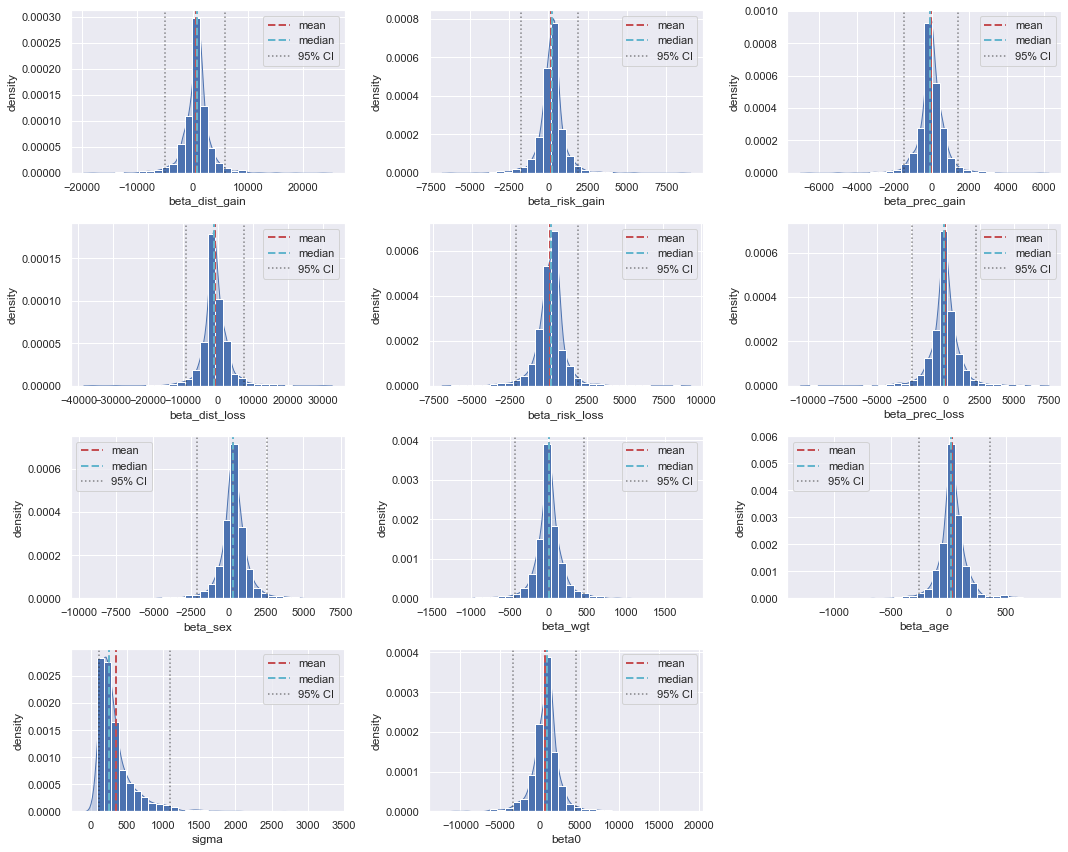

In [59]:
params = (
    "beta_dist_gain", "beta_risk_gain", "beta_prec_gain", 
    "beta_dist_loss", "beta_risk_loss", "beta_prec_loss",
    "beta_sex", "beta_wgt", "beta_age",
    "sigma", "beta0")
nrows=4
ncols=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
axes = axes.flatten()

for i, param_name in enumerate(params):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    ax = axes[i]
    ax.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    ax.legend()
    
for i in range(len(params), ncols*nrows):
    fig.delaxes(axes[i])
    
plt.tight_layout()    
plt.show()

# Model 2 (with age, weight and gender)

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{sex} sex + \beta_{age} age + \beta_{weight} weight + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [69]:
model = """
data {
    int<lower=0> N;
    vector[N] weight;
    vector[N] age;
    vector[N] sex;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_age;
    real beta_sex;
    real beta_wgt;
    real<lower=0> sigma;
}
model {
    elo ~ normal(
        beta0 
        + beta_age * age
        + beta_wgt * weight
        + beta_sex * sex
        , sigma);
}
"""

## Compile the model

In [70]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_file = os.path.join(BACKUP_FOLDER, 'regression_model3.pkl')
if not os.path.exists(bkp_file) or force_compilation:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_329d4f911b3ae87962ec779fb806ca55 NOW.


## Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [75]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=10000, chains=4, warmup=1000, thin=1, seed=101,
                  control=dict(adapt_delta=0.9,))
fit

Inference for Stan model: anon_model_329d4f911b3ae87962ec779fb806ca55.
4 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=36000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0     350.7    1.13 134.62  84.26 268.14 351.71 433.16 624.22  14137    1.0
beta_age   2.55    0.11  12.04 -21.65   -4.9   2.46   9.98  26.73  11530    1.0
beta_sex  93.55    1.17 127.47 -161.0  14.56  92.17 172.23 348.62  11809    1.0
beta_wgt  52.06    0.15   16.0  19.91  42.27  52.15  62.03  83.67  11967    1.0
sigma    115.36    0.33  33.72  70.12  92.22 108.75 130.77 199.81  10279    1.0
lp__     -62.53    0.02   2.04 -67.61 -63.55 -62.11 -61.02 -59.86   7930    1.0

Samples were drawn using NUTS at Wed Jan 13 17:27:42 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [76]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,350.698016,1.132253,134.622168,84.255079,268.137703,351.714706,433.157773,624.216127,14136.647770,1.000129
beta_age,2.545811,0.112137,12.040869,-21.650656,-4.897376,2.461150,9.976090,26.733062,11529.774760,1.000328
beta_sex,93.550954,1.172989,127.465840,-161.015575,14.560034,92.170532,172.232623,348.623108,11808.640400,1.000325
beta_wgt,52.062558,0.146262,16.000379,19.906593,42.266781,52.153584,62.025244,83.667891,11967.364773,1.000533
sigma,115.361527,0.332635,33.724720,70.118214,92.220385,108.749060,130.766256,199.813756,10279.233100,1.000450
lp__,-62.529471,0.022871,2.036644,-67.609422,-63.550191,-62.107549,-61.022962,-59.860519,7929.564127,1.000694


## Plot the results

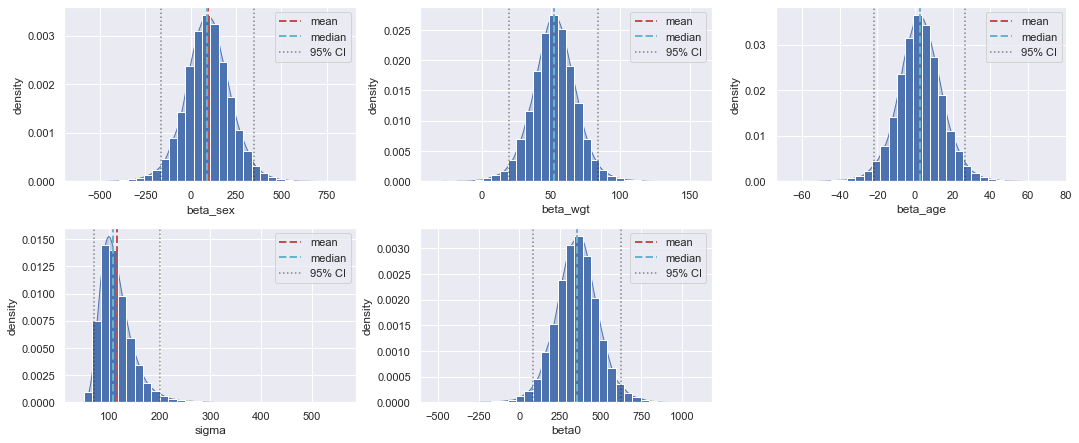

In [77]:
params = (
    "beta_sex", "beta_wgt", "beta_age",
    "sigma", "beta0")
nrows=4
ncols=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
axes = axes.flatten()

for i, param_name in enumerate(params):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    ax = axes[i]
    ax.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    ax.legend()
    
for i in range(len(params), ncols*nrows):
    fig.delaxes(axes[i])
    
plt.tight_layout()    
plt.show()

# With alternative decision-making models

In [13]:
MODEL = ModelLocBias 

## Load the fit

In [14]:
df_fit = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_fit_overall{DATASET}_{MODEL.__name__}.csv"))
for c in ("date_begin", "date_end"):
    df_fit[c] = pd.to_datetime(df_fit[c])
df_fit.drop(df_fit.filter(regex="Unname"),axis=1, inplace=True)
df_fit

,distortion,precision,risk_aversion,loc_bias,date_begin,date_end,monkey,condition,n
0,1.327775,0.285684,0.206004,0.051842,2020-02-22,2020-06-22,Ala,gain,8326
1,1.051529,0.231330,-0.582592,-0.071694,2020-02-22,2020-06-22,Ala,loss,8285
2,0.768159,0.447276,0.075584,-0.936214,2020-02-22,2020-06-22,Alv,gain,9996
3,0.462213,0.229596,-0.398661,-0.675575,2020-02-22,2020-06-22,Alv,loss,9988
4,0.915509,0.492803,-0.109141,-0.117283,2020-02-22,2020-06-22,Bar,gain,10361
5,0.769959,0.189979,-0.640682,-0.121369,2020-02-22,2020-06-22,Bar,loss,10365
6,0.250000,1.612589,0.083753,-10.000000,2020-02-23,2020-06-22,Ola,gain,5235
7,0.250000,0.330200,-0.903815,-1.570219,2020-02-23,2020-06-22,Ola,loss,5237
8,0.610421,0.704556,0.750000,2.518428,2020-05-20,2020-06-18,Yin,gain,389
9,0.888765,2.477640,0.571941,10.000000,2020-05-20,2020-06-19,Yin,loss,382


## Prepare the data

In [30]:
elo = []

for _, row in df_fit.iterrows():
        
    m = row.monkey
    begin = row.date_begin
    end = row.date_end
        
    df_elo_m = df_elo[m.lower()]
    df_elo_m = df_elo_m[(df_elo_m.index >= begin) & (df_elo_m.index <= end)]
    elo.append(np.mean(df_elo_m))
        

df_fit['elo'] = elo

In [31]:
left = df_fit[df_fit.condition == "loss"]
right = df_fit[df_fit.condition == "gain"]
df = pd.merge(left, right, on=("monkey", "elo", "date_begin", "date_end"), suffixes=('_loss', '_gain'))
df.drop("condition_gain", axis=1, inplace=True)
df.drop("condition_loss", axis=1, inplace=True)
for i, row in df.iterrows():
    try:
        df.loc[i, "age"] = df_demo.loc[df_demo.monkey == row.monkey, 'age'].item()
        df.loc[i, "weight"] = df_demo.loc[df_demo.monkey == row.monkey, 'weight'].item()
        df.loc[i, "sex"] = int(df_demo.loc[df_demo.monkey == row.monkey, 'sex'].item() == "M")
    except IndexError:
        print(row.monkey)

df.loc_bias_loss = np.abs(df.loc_bias_loss.values)
df.loc_bias_gain = np.abs(df.loc_bias_gain.values)
df

,distortion_loss,precision_loss,risk_aversion_loss,loc_bias_loss,date_begin,date_end,monkey,n_loss,elo,distortion_gain,precision_gain,risk_aversion_gain,loc_bias_gain,n_gain,age,weight,sex
0,1.051529,0.231330,-0.582592,0.071694,2020-02-22,2020-06-22,Ala,8285,1106.786885,1.327775,0.285684,0.206004,0.051842,8326,7.823804,12.6,1.0
1,0.462213,0.229596,-0.398661,0.675575,2020-02-22,2020-06-22,Alv,9988,1096.295082,0.768159,0.447276,0.075584,0.936214,9996,7.919631,14.6,1.0
2,0.769959,0.189979,-0.640682,0.121369,2020-02-22,2020-06-22,Bar,10365,998.040984,0.915509,0.492803,-0.109141,0.117283,10361,6.109874,10.6,1.0
3,0.250000,0.330200,-0.903815,1.570219,2020-02-23,2020-06-22,Ola,5237,1426.305785,0.250000,1.612589,0.083753,10.000000,5235,8.938132,16.5,1.0
4,0.610913,0.486384,-0.389759,0.044906,2020-02-22,2020-06-22,Abr,6302,1262.409836,0.674636,0.315598,0.650498,0.154676,6299,7.670481,12.7,1.0
5,3.146037,4.364985,0.009900,2.918730,2020-02-22,2020-06-22,Nem,5001,906.327869,4.000000,4.075483,-0.012649,2.841584,5008,10.025081,9.2,0.0
6,0.896678,0.456582,-0.223548,0.207527,2020-02-23,2020-06-22,Ces,5632,757.801653,0.682652,0.293991,0.571963,0.234865,5636,5.611575,6.8,1.0
7,0.556572,3.342894,-1.932573,5.533494,2020-02-23,2020-06-22,Anu,3480,1174.388430,0.483596,0.274798,0.439750,0.415323,3494,7.651316,15.5,1.0
8,0.801598,0.371508,-0.657946,0.156579,2020-02-23,2020-06-22,Yoh,2840,806.785124,0.975279,0.337290,0.730696,0.478002,2851,11.478910,10.0,0.0
9,0.595455,0.338832,-0.608765,0.054098,2020-02-26,2020-06-22,Oli,2032,1203.288136,4.000000,3.507992,-0.016318,5.928025,2034,10.126384,15.0,1.0


In [32]:
# Convert dataframe into a dictionary adapted to Stan
data = df.to_dict('list')
data['N'] = len(data["distortion_gain"])
data.pop("date_begin")
data.pop("date_end")
data.pop("monkey")
data

{'distortion_loss': [1.051529467157979,
  0.4622131281571543,
  0.7699585963504393,
  0.25,
  0.6109125797351685,
  3.146036570449859,
  0.8966781115273805,
  0.556572275725286,
  0.8015981312053857,
  0.5954549524079402,
  3.983403523205157,
  0.4668170725989621,
  0.485292203325193],
 'precision_loss': [0.2313303691209499,
  0.2295961493873237,
  0.189979067905256,
  0.330199715939069,
  0.4863837404951076,
  4.364985284228846,
  0.4565824946141308,
  3.342894494315603,
  0.3715076743999835,
  0.338832463798926,
  4.907822929160847,
  2.279537604000585,
  0.5929277700603497],
 'risk_aversion_loss': [-0.5825924920704907,
  -0.3986605696920334,
  -0.6406817224728456,
  -0.903815405175226,
  -0.3897588210600837,
  0.0099002417141462,
  -0.2235479599175706,
  -1.9325730467876163,
  -0.6579458902929478,
  -0.6087650594801851,
  -0.9530342966963048,
  0.75,
  -0.7938769796716547],
 'loc_bias_loss': [0.0716940938334852,
  0.675574714920218,
  0.1213685594431351,
  1.570219396774808,
  0.044

# Model 1

## Define the model

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [25]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] loc_bias_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] loc_bias_loss;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_loca_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real beta_loca_loss;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_gain * distortion_gain
    + beta_risk_gain * risk_aversion_gain
    + beta_prec_gain * precision_gain
    + beta_dist_loss * distortion_loss
    + beta_risk_loss * risk_aversion_loss
    + beta_prec_loss * precision_loss
    + beta_loca_gain * loc_bias_gain
    + beta_loca_loss * loc_bias_loss
    , sigma);
}
"""

## Compile the model

In [44]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_file = os.path.join(BACKUP_FOLDER, 'regression_model_LOC.pkl')
if not os.path.exists(bkp_file) or force_compilation:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

## Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [53]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=5000, chains=4, warmup=1000, thin=1, seed=101,
                  control={"adapt_delta": 0.99, "max_treedepth":15})
fit

Inference for Stan model: anon_model_affb982ae7ef65a5b2600967de061d61.
4 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          1773.9   12.16 602.65 612.77 1480.9 1778.3 2061.5 2949.0   2456    1.0
beta_dist_gain 934.74   11.03 492.47 -29.03 687.89 932.97 1172.7 1923.7   1992    1.0
beta_risk_gain -864.4    8.97  501.8  -1844  -1102 -865.1 -624.7  93.05   3128    1.0
beta_prec_gain  -1628   19.11 815.44  -3290  -2024  -1622  -1218  -21.0   1821    1.0
beta_loca_gain 339.64    3.65 156.98  31.52 261.58 337.95 417.29 655.99   1848    1.0
beta_dist_loss  -1064   15.95 676.16  -2432  -1398  -1065 -726.3 266.56   1796    1.0
beta_risk_loss 700.55   11.11 483.24 -243.9 460.71 701.95 936.11 1674.3   1893    1.0
beta_prec_loss 1367.7   19.19 802.28 -207.9 962.19 1368.7 1762.3 3002.7   1748    1.0
beta_loca_loss -536.7    7.79 329.35

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [54]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,1773.911062,12.160127,602.654142,612.774219,1480.968099,1778.340075,2061.521371,2949.085737,2456.179256,1.002671
beta_dist_gain,934.740130,11.033243,492.467376,-29.034362,687.891741,932.965780,1172.778776,1923.707695,1992.271564,1.001624
beta_risk_gain,-864.436771,8.972102,501.795725,-1844.506526,-1102.167268,-865.164756,-624.783744,93.050721,3127.990993,1.002449
beta_prec_gain,-1628.178270,19.108513,815.435187,-3289.999737,-2024.927739,-1622.637594,-1218.256049,-20.999667,1821.063587,1.002026
beta_loca_gain,339.638242,3.651264,156.982929,31.524778,261.578753,337.946217,417.285031,655.991146,1848.495743,1.001814
beta_dist_loss,-1064.847344,15.954348,676.159845,-2432.681022,-1398.480528,-1065.980042,-726.313663,266.559561,1796.141817,1.002225
beta_risk_loss,700.548317,11.106252,483.239958,-243.919473,460.710924,701.953680,936.108087,1674.351463,1893.174354,1.002214
beta_prec_loss,1367.724465,19.187511,802.276011,-207.929078,962.193389,1368.756288,1762.337993,3002.706961,1748.277421,1.002268
beta_loca_loss,-536.761600,7.792438,329.353615,-1205.082522,-698.056410,-536.509667,-370.842497,123.099552,1786.397757,1.002233
sigma,218.657246,5.394202,155.967490,91.744229,138.161061,180.742387,250.086129,572.271372,836.014541,1.005243


## Plot the results

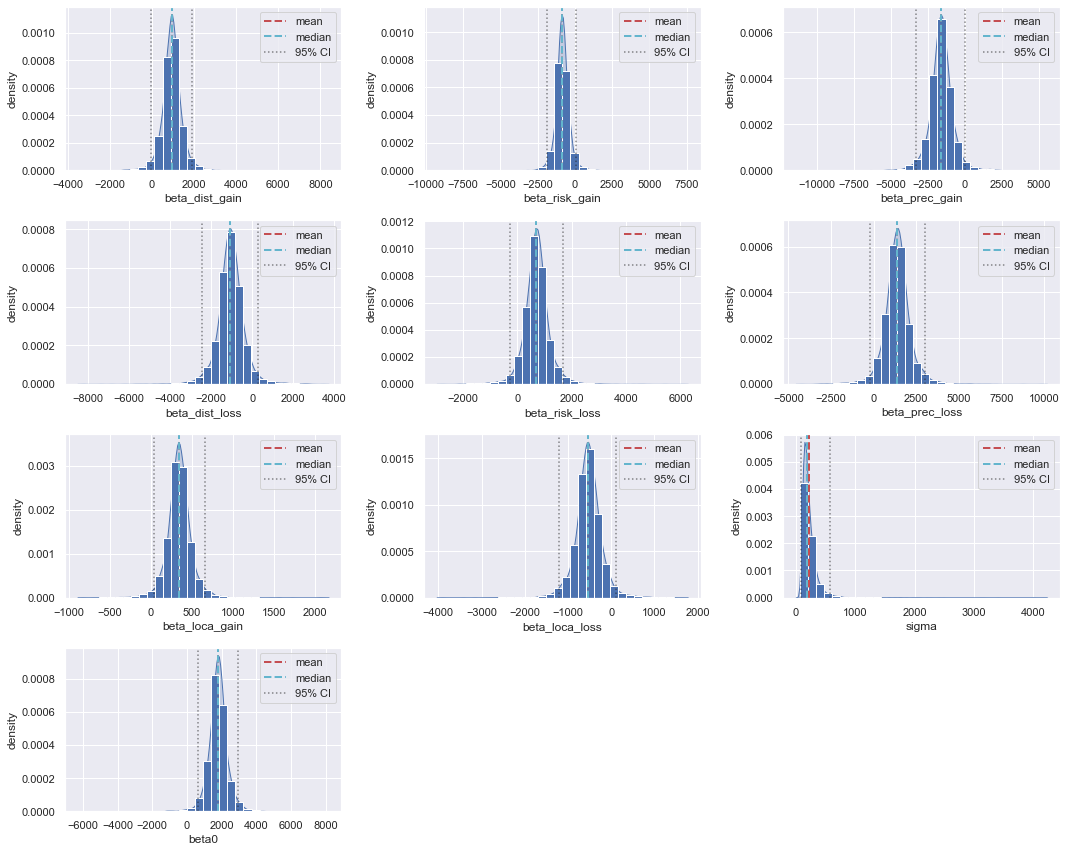

In [55]:
params = (
    "beta_dist_gain", "beta_risk_gain", "beta_prec_gain", 
    "beta_dist_loss", "beta_risk_loss", "beta_prec_loss",
    "beta_loca_gain", "beta_loca_loss",
    "sigma", "beta0")
nrows=4
ncols=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
axes = axes.flatten()

for i, param_name in enumerate(params):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    ax = axes[i]
    ax.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    ax.legend()
    
for i in range(len(params), ncols*nrows):
    fig.delaxes(axes[i])
    
plt.tight_layout()    
plt.show()